In [19]:
import os
from glob import glob

# CHANGE THESE TO YOUR MOL AND JDX FOLDERS
MOL_FOLDER = 'C:\\Users\\20234238\\Year_2\\Q4\\Untitled Folder\\scraper\\mol'
JDX_FOLDER = 'C:\\Users\\20234238\\Year_2\\Q4\\Untitled Folder\\scraper\\jdx'

mol_files = glob(os.path.join(MOL_FOLDER, '*.mol'))
jdx_files = glob(os.path.join(JDX_FOLDER, '*.jdx'))

jdx_cas_to_jdx_path = {}
for jdx_path in jdx_files:
    jdx_cas_with_index = os.path.splitext(os.path.basename(jdx_path))[0]
    jdx_cas_to_jdx_path[jdx_cas_with_index] = os.path.abspath(jdx_path)
    
mol_to_jdx = {}

# Find out which .jdx files belong to which .mol files
for mol_path in mol_files:
    mol_cas = os.path.splitext(os.path.basename(mol_path))[0]
    matching_jdx = []
    
    index = 0
    while (True):
        cas_with_index = mol_cas + ("-IR-%i" % (index))
        if cas_with_index in jdx_cas_to_jdx_path:
            matching_jdx.append(jdx_cas_to_jdx_path[cas_with_index])
            index = index + 1
        else:
            break
    
    mol_to_jdx[os.path.abspath(mol_path)] = matching_jdx
    
print('Files:')
for mol_file, jdx_list in mol_to_jdx.items():
    print('\nMOL: %s' % (mol_file))
    for jdx_file in jdx_list:
        print("\tJDX: %s" % (jdx_file))

Files:

MOL: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\mol\10-05-9.mol

MOL: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\mol\10-15-1.mol

MOL: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\mol\10-90-2.mol

MOL: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\mol\10-94-6.mol

MOL: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\mol\10-95-7.mol

MOL: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\mol\10-99-1.mol

MOL: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\mol\100-00-5.mol
	JDX: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\jdx\100-00-5-IR-0.jdx
	JDX: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\jdx\100-00-5-IR-1.jdx

MOL: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\mol\100-01-6.mol
	JDX: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\jdx\100-01-6-IR-0.jdx
	JDX: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\jdx\100-01-6-IR-1.jdx

MOL: C:\Users\20234238\Year_2\Q4\Untitled Folder\scraper\mol\100-02-7.mol
	JDX

In [20]:
def is_jdx_valid(jdx_file):
    try:
        with open(jdx_file, 'r') as file:
            content = file.read()
            
            # Measurements in these jdx files are always preceded by ##XYDATA=. Some files don't contain any measurements so we throw them away
            if (not ('##XYDATA=' in content)):
                return False
            
            return True
    except FileNotFoundError:
        print('File %s does not exist!' % (jdx_file))
        return False

for mol_file, jdx_list in mol_to_jdx.items():
    mol_to_jdx[mol_file] = [jdx for jdx in jdx_list if is_jdx_valid(jdx)]
    
# Remove .mol files for which there is no IR data
for key in list(mol_to_jdx):
    if mol_to_jdx[key] == []:
        del mol_to_jdx[key]

jdx_count = 0
for mol_file, jdx_list in mol_to_jdx.items():
    for jdx_file in jdx_list:
        jdx_count = jdx_count + 1
print('%i .jdx files corresponding to %i .mol files' % (jdx_count, len(mol_to_jdx)))

5688 .jdx files corresponding to 4615 .mol files


In [24]:
import re
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pandas as pd
import matplotlib.pyplot as plt


functional_group_patterns = {
    #'group_name': Chem.MolFromSmarts['smarts_code']
    'alkane': Chem.MolFromSmarts('[CX4;H3,H2]'),
    'alkene': Chem.MolFromSmarts('[CX3]=[CX3]'),
    'alkyne': Chem.MolFromSmarts('[CX2]#[CX2]'),
    'arene': Chem.MolFromSmarts('[cX3]1[cX3][cX3][cX3][cX3][cX3]1'),
    'haloalkane': Chem.MolFromSmarts('[#6][F,Cl,Br,I]'),
    'alcohol': Chem.MolFromSmarts('[#6][OX2H]'),
    'aldehyde': Chem.MolFromSmarts('[CX3H1](=O)[#6,H]'),
    'ketone': Chem.MolFromSmarts('[#6][CX3](=O)[#6]'),
    'carboxylic_acid': Chem.MolFromSmarts('[CX3](=O)[OX2H]'),
    'acid_anhydride': Chem.MolFromSmarts('[CX3](=[OX1])[OX2][CX3](=[OX1])'),
    'acyl_halide': Chem.MolFromSmarts('[CX3](=[OX1])[F,Cl,Br,I]'),
    'ester': Chem.MolFromSmarts('[#6][CX3](=O)[OX2H0][#6]'),
    'ether': Chem.MolFromSmarts('[OD2]([#6])[#6]'),
    'amine': Chem.MolFromSmarts('[NX3;H2,H1,H0;!$(NC=O)]'),
    'amide': Chem.MolFromSmarts('[NX3][CX3](=[OX1])[#6]'),
    'nitrile': Chem.MolFromSmarts('[NX1]#[CX2]'),
    'imide': Chem.MolFromSmarts('[CX3](=[OX1])[NX3][CX3](=[OX1])'),
    'imine': Chem.MolFromSmarts('[$([CX3]([#6])[#6]),$([CX3H][#6])]=[$([NX2][#6]),$([NX2H])]'),
    'azo_compound': Chem.MolFromSmarts('[#6][NX2]=[NX2][#6]'),
    'thiol': Chem.MolFromSmarts('[#16X2H]'),
    'thial': Chem.MolFromSmarts('[CX3H1](=O)[#6,H]'),
    'sulfone': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[#6]'),
    'sulfonic_acid': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[OX2H]'),
    'enol': Chem.MolFromSmarts('[OX2H][#6X3]=[#6]'),
    'phenol': Chem.MolFromSmarts('[OX2H][cX3]:[c]'),
    'hydrazine': Chem.MolFromSmarts('[NX3][NX3]'),
    'enamine': Chem.MolFromSmarts('[NX3][CX3]=[CX3]'),
    'isocyanate': Chem.MolFromSmarts('[NX2]=[C]=[O]'),
    'isothiocyanate': Chem.MolFromSmarts('[NX2]=[C]=[S]'),
    'phosphine': Chem.MolFromSmarts('[PX3]'),
    'sulfonamide': Chem.MolFromSmarts('[#16X4]([NX3])(=[OX1])(=[OX1])[#6]'),
    'sulfonate': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[OX2H0]'),
    'sulfoxide': Chem.MolFromSmarts('[#16X3]=[OX1]'),
    'thioamide': Chem.MolFromSmarts('[NX3][CX3]=[SX1]'),
    'hydrazone': Chem.MolFromSmarts('[NX3][NX2]=[#6]'),
    'carbamate': Chem.MolFromSmarts('[NX3][CX3](=[OX1])[OX2H0]'),
    'sulfide': Chem.MolFromSmarts('[#16X2H0]')
}

def determine_functional_groups(mol_file):
    mol = Chem.MolFromMolFile(mol_file)
    
    if mol is None:
        return []
    
    functional_groups = []
    for functional_group in functional_group_patterns:
        if mol.HasSubstructMatch(functional_group_patterns[functional_group]):
            functional_groups.append(functional_group)
    return functional_groups


def get_state(jdx_file):
    try:
        with open(jdx_file, 'r') as file:
            lines = file.readlines()
            
            for line in lines:
                if line.startswith('##STATE='):
                    state = line[len('##STATE='):].strip().lower()
                    return re.split(r"[;, ()]+", state)[0]
            return 'Unknown'
    except FileNotFoundError:
        print('File %s does not exist!' % (jdx_file))
        return False
    
    
molecules_with_functional_group = {}
samples_with_functional_group = {}

number_of_functional_groups_mols = []
number_of_functional_groups_samples = []

states = {}


for mol_file, jdx_list in mol_to_jdx.items():
    functional_groups = determine_functional_groups(mol_file)
    
    # Functional groups
    for functional_group in functional_groups:
        if functional_group in molecules_with_functional_group:
            molecules_with_functional_group[functional_group] = molecules_with_functional_group[functional_group] + 1
            samples_with_functional_group[functional_group] = samples_with_functional_group[functional_group] + len(mol_to_jdx[mol_file])
        else:
            molecules_with_functional_group[functional_group] = 1
            samples_with_functional_group[functional_group] = len(mol_to_jdx[mol_file])
            
    # Number of functional groups
    number_of_groups = len(functional_groups)
    if (number_of_groups < len(number_of_functional_groups_mols)):
        number_of_functional_groups_mols[number_of_groups] = number_of_functional_groups_mols[number_of_groups] + 1
        number_of_functional_groups_samples[number_of_groups] = number_of_functional_groups_samples[number_of_groups] + len(mol_to_jdx[mol_file])
    else:
        number_of_functional_groups_mols.insert(number_of_groups, 1)
        number_of_functional_groups_samples.insert(number_of_groups, len(mol_to_jdx[mol_file]))
        
    # Spectrum states
    for jdx_file in jdx_list:
        state = get_state(jdx_file)
        if state in states:
            states[state] = states[state] + 1
        else:
            states[state] = 1
            
print(molecules_with_functional_group)
print(samples_with_functional_group)

print(number_of_functional_groups_mols)
print(number_of_functional_groups_samples)

print(states)

{'arene': 2216, 'haloalkane': 973, 'amine': 1033, 'alcohol': 953, 'phenol': 272, 'alkane': 3628, 'ketone': 389, 'ether': 1296, 'aldehyde': 104, 'thial': 104, 'hydrazine': 52, 'acyl_halide': 34, 'isocyanate': 18, 'alkene': 597, 'nitrile': 161, 'thiol': 61, 'sulfonamide': 45, 'carbamate': 63, 'amide': 322, 'ester': 629, 'alkyne': 67, 'sulfide': 235, 'carboxylic_acid': 264, 'hydrazone': 38, 'imide': 69, 'phosphine': 19, 'azo_compound': 20, 'sulfone': 37, 'enamine': 19, 'imine': 32, 'isothiocyanate': 64, 'sulfonic_acid': 7, 'sulfonate': 11, 'acid_anhydride': 15, 'thioamide': 26, 'enol': 4, 'sulfoxide': 9}
{'arene': 2626, 'haloalkane': 1163, 'amine': 1167, 'alcohol': 1111, 'phenol': 326, 'alkane': 4497, 'ketone': 440, 'ether': 1593, 'aldehyde': 134, 'thial': 134, 'hydrazine': 54, 'acyl_halide': 37, 'isocyanate': 18, 'alkene': 812, 'nitrile': 217, 'thiol': 67, 'sulfonamide': 47, 'carbamate': 68, 'amide': 345, 'ester': 816, 'alkyne': 72, 'sulfide': 252, 'carboxylic_acid': 298, 'hydrazone': 43

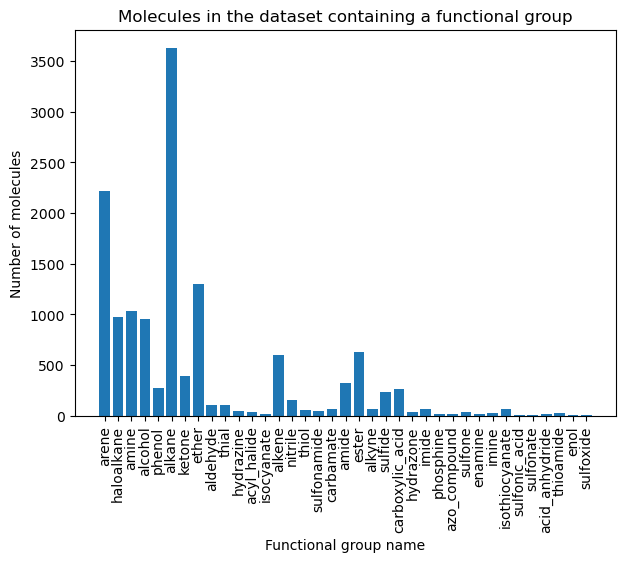

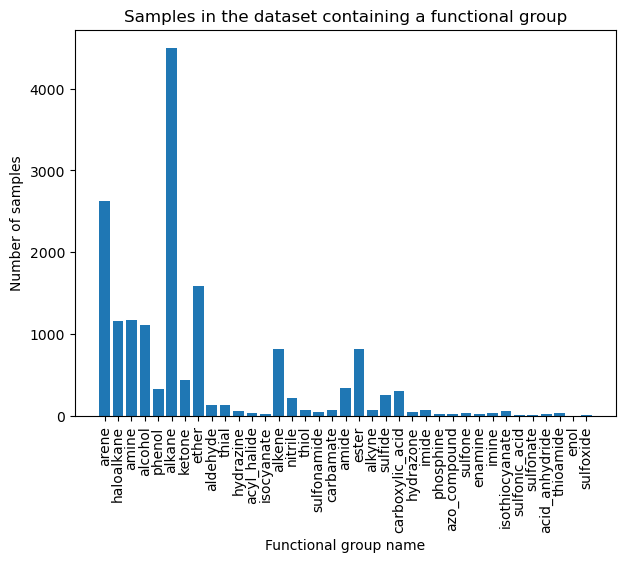

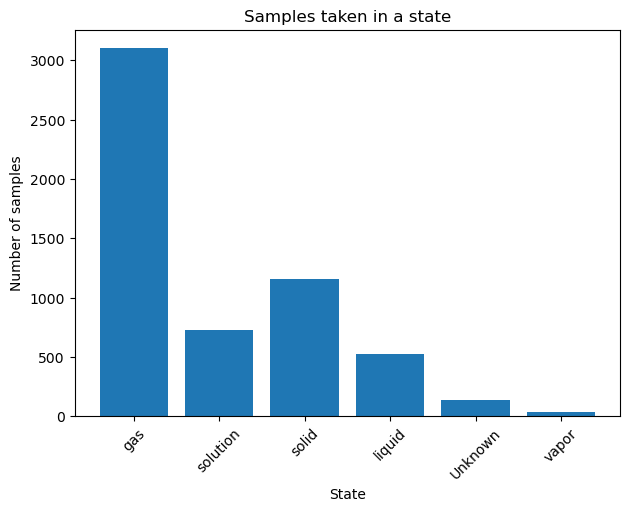

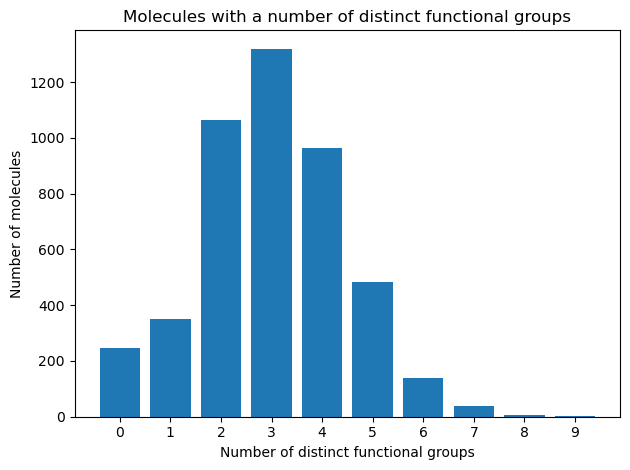

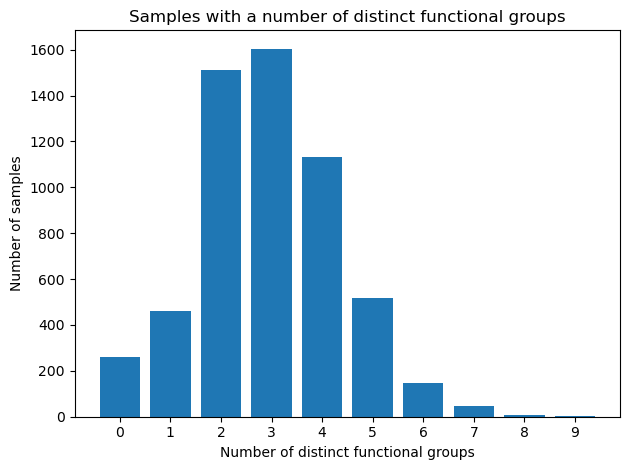

In [30]:
# Used to prevent states with only a few samples from cluttering the state graph 
DISPLAY_THRESHOLD = 20
# CHANGE THIS TO THE FOLDER WHERE YOU WANT TO SAVE THE GRAPHS
PLT_PATH = 'plot_images'

# FUNCTIONAL GROUP COUNTS MOLECULES
group_names_mol = list(molecules_with_functional_group.keys())
group_counts_mol = list(molecules_with_functional_group.values())

plt.bar(group_names_mol, group_counts_mol)
plt.xlabel('Functional group name')
plt.ylabel('Number of molecules')
plt.title('Molecules in the dataset containing a functional group')
plt.tight_layout()
plt.xticks(rotation=90)

plt_path = os.path.join(PLT_PATH, 'functional_groups_mol.png')
#bbox_inches is needed to prevent some of the labels from getting cropped out
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# FUNCTIONAL GROUP COUNTS SAMPLES/SPECTRA
group_names_samples = list(samples_with_functional_group.keys())
group_counts_samples = list(samples_with_functional_group.values())

plt.bar(group_names_samples, group_counts_samples)
plt.xlabel('Functional group name')
plt.ylabel('Number of samples')
plt.title('Samples in the dataset containing a functional group')
plt.tight_layout()
plt.xticks(rotation=90)

plt_path = os.path.join(PLT_PATH, 'functional_groups_sample.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# SAMPLE/SPECTRUM STATES
state_names = [state for state in list(states.keys()) if states[state] >= DISPLAY_THRESHOLD]
state_counts = [count for count in list(states.values()) if count >= DISPLAY_THRESHOLD]
plt.bar(state_names, state_counts)
plt.xlabel('State')
plt.ylabel('Number of samples')
plt.title('Samples taken in a state')
plt.tight_layout()
plt.xticks(rotation=45)

plt_path = os.path.join(PLT_PATH, 'states.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# NUMBER OF MOLECULES WITH SOME NUMBER OF UNIQUE FUNCTIONAL GROUPS
plt.bar(range(len(number_of_functional_groups_mols)), number_of_functional_groups_mols)
plt.xlabel('Number of distinct functional groups')
plt.ylabel('Number of molecules')
plt.title('Molecules with a number of distinct functional groups')
plt.xticks(ticks=range(len(number_of_functional_groups_mols)))
plt.tight_layout()

plt_path = os.path.join(PLT_PATH, 'number_of_groups_mol.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# NUMBER OF SAMPLES WITH SOME NUMBER OF UNIQUE FUNCTIONAL GROUPS
plt.bar(range(len(number_of_functional_groups_samples)), number_of_functional_groups_samples)
plt.xlabel('Number of distinct functional groups')
plt.ylabel('Number of samples')
plt.title('Samples with a number of distinct functional groups')
plt.xticks(ticks=range(len(number_of_functional_groups_samples)))
plt.tight_layout()

plt_path = os.path.join(PLT_PATH, 'number_of_groups_sample.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()